# Ribonanza - Attempt 3

A second approach to the [Stanford Ribonanza problem](https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding/) that builds off the first approach.

Major differences:
- use of attention model architecture
- use of only filtered data (data in which SN_filter == 1)

Currently, the attention architecture scores 0.21969

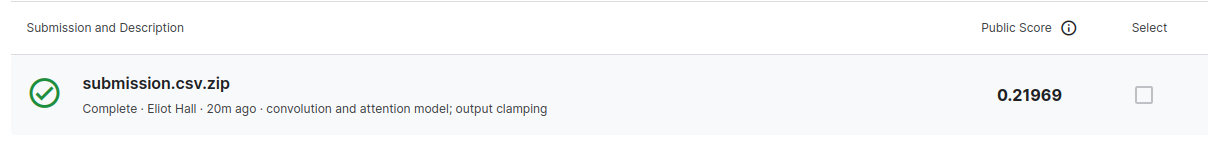

## Todo

- improve model 

## Setup

### Filesystem Setup

Your project directory should look like this:

- `(project directory)`
    - `ribonanza2.ipynb`
    - `train_data.csv`
    - `test_data.csv` (optional)

`train_data.csv` is the only file necessary for training, and it can be downloaded from the kaggle competition linked in the description.

`test_data.csv` is only necessary if you intend to make and submit predictions.

### Code Setup

In [1]:
# imports
import tensorflow as tf
import keras.layers as layers
import keras
import pandas
import numpy as np
from tqdm import tqdm
import seaborn
import os

In [2]:
# constants

# according to kaggle, this is the maximum # of reactivites to be used
NUM_REACTIVITIES = 457

# there are 4 different bases (AUCG)
NUM_BASES = 4

## Data Preprocessing

### Filter Data

In [3]:
def filter_data(out: str, key: str, value: str, file_name: str, force: bool):
    """
    Filters a file to only take datapoints
    whose values of `key` are `value`.

    Parameters:
        - out: str - the name of the file that will store the filtered datapoints
        - key: str - the name of the key to look at
        - value: str - the value that the key should have
        - file_name: str - the name of the file that contains all the datapoints.
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    if os.path.exists(out) and not force:
        print("File already exists, not doing any work")
        return

    count = 0

    # count how many lines we have in total
    with open(file_name) as file:
        line = file.readline()  # ignore the header
        line = (
            file.readline()
        )  # take the first line since we increment count in the loop
        while line != "":
            count += 1
            line = file.readline()

    # use that knowledge for a progress bar
    with open(file_name, "r") as file, open(out, "w") as outfile:
        # write the header
        header = file.readline()
        outfile.write(header)

        # get what index the SN_filter is
        SN_idx = header.split(",").index(key)

        # only take the approved filtered lines
        for _ in tqdm(range(count)):
            line = file.readline()
            temp = line.split(",")
            if temp[SN_idx] == value:
                outfile.write(line)


def filter_train_data(force: bool = False):
    """
    Filters the immense train_data.csv to only take datapoints
    whose SN_filter (Signal to Noise filter) is 1. In other words,
    we only take good reads. These filtered datapoints are then
    written to the file provided

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data("train_data_filtered.csv", "SN_filter", "1", "train_data.csv", force)


def filter_2A3(force: bool = False):
    """
    Only take the 2A3 points

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data(
        "train_data_2a3.csv",
        "experiment_type",
        "2A3_MaP",
        "train_data_filtered.csv",
        force,
    )


def filter_DMS(force: bool = False):
    """
    Only take the DMS points

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data(
        "train_data_dms.csv",
        "experiment_type",
        "DMS_MaP",
        "train_data_filtered.csv",
        force,
    )

In [4]:
# filter our data
filter_train_data()

File already exists, not doing any work


In [5]:
# take the 2a3 points
filter_2A3()

File already exists, not doing any work


In [6]:
# take the dms points
filter_DMS()

File already exists, not doing any work


### Convert Data to Inputs and Outputs

In [7]:
# encode inputs as
# A : [1, 0, 0, 0]
# U : [0, 1, 0, 0]
# C : [0, 0, 1, 0]
# G : [0, 0, 0, 1]
base_map = {
    "A": np.array([1, 0, 0, 0]),
    "U": np.array([0, 1, 0, 0]),
    "C": np.array([0, 0, 1, 0]),
    "G": np.array([0, 0, 0, 1]),
}

In [8]:
def preprocess_csv(out: str, file_name: str, force: bool = False):
    """
    Preprocess the csv and save the preprocessed data as a .npz file

    Parameters:
        - out: str - the name of the file to save the arrays to
        - file_name: str - the name of the input csv file
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done).
                Defaults to `False`
    """
    if os.path.exists(out) and not force:
        print("File already exists, not doing any work")
        return

    df = pandas.read_csv(file_name)

    inputs = np.zeros((len(df), NUM_REACTIVITIES, NUM_BASES))
    outputs = np.zeros((len(df), NUM_REACTIVITIES))
    output_masks = np.ones((len(df), NUM_REACTIVITIES), dtype=np.bool_)
    errors = np.zeros((len(df), NUM_REACTIVITIES))

    for index in tqdm(range(len(df))):
        row = df.iloc[index]

        # get the sequence
        seq_len = len(row["sequence"])

        # map the base to its one-hot encoding
        inputs[index, :seq_len] = np.array(
            list(map(lambda letter: base_map[letter], row["sequence"]))
        )

        # get all the reactivities and reactivity errors
        reactivities = np.array(
            list(
                map(
                    lambda seq_idx: row["reactivity_" + str(seq_idx + 1).rjust(4, "0")],
                    range(seq_len),
                )
            )
        )
        reactivity_errors = np.array(
            list(
                map(
                    lambda seq_idx: row[
                        "reactivity_error_" + str(seq_idx + 1).rjust(4, "0")
                    ],
                    range(seq_len),
                )
            )
        )

        # replace reactivity error nans with 0s (assume no error)
        reactivity_errors = np.where(
            np.isnan(reactivity_errors), 0.0, reactivity_errors
        )

        # get where all the reactivities are nan
        nan_locats = np.isnan(reactivities)

        # where it is nan, store True, else false
        output_masks[index, :seq_len] = nan_locats

        # where it is not nan, store the reactivity and error, else 0
        outputs[index, :seq_len] = np.where(nan_locats == False, reactivities, 0.0)
        errors[index, :seq_len] = np.where(nan_locats == False, reactivity_errors, 0.0)

    # save the outputs
    np.savez_compressed(
        out, inputs=inputs, outputs=outputs, output_masks=output_masks, errors=errors
    )

In [9]:
preprocess_csv("train_data_2a3_preprocessed.npz", "train_data_2a3.csv")

File already exists, not doing any work


In [10]:
preprocess_csv("train_data_dms_preprocessed.npz", "train_data_dms.csv")

File already exists, not doing any work


### Load the desired dataset

In [11]:
desired_dataset = "2a3"  # either "2a3" or "dms"

In [12]:
# load the npz file
npz_file = np.load(f"train_data_{desired_dataset}_preprocessed.npz")

# stored inputs, outputs, and output_masks
# note: if visualizing, you may just want to only load outputs and bool_output_masks
# since histplot takes a lot of RAM.
inputs, outputs, bool_output_masks, errors = (
    npz_file["inputs"],
    npz_file["outputs"],
    npz_file["output_masks"],
    npz_file["errors"],
)

# close the npz file
npz_file.close()

In [13]:
# convert to usable weights:
# if it is meant to be masked, it should be worth 0, else it should be worth 1 - error
output_masks = np.where(bool_output_masks, 0.0, 1.0)
output_masks -= errors
output_masks[output_masks < 0.0] = 0.0
output_masks.shape

(210992, 457)

In [14]:
outputs = np.clip(outputs, 0, 1)

### Visualize

This section of the notebook allows for visualizing the reactivities of the
current dataset.

In [15]:
visualize = False

In [16]:
if visualize:
    visualized_items = []
    for i in tqdm(range(len(outputs))):
        for x in range(NUM_REACTIVITIES):
            if not bool_output_masks[i, x]:
                visualized_items.append(outputs[i, x])
    visualized_items = np.array(visualized_items)
    print(f"took {len(visualized_items)}/{len(outputs)*NUM_REACTIVITIES} reactivities")
else:
    print("Not visualizing. Set `visualize` to `True` to visualize data")

Not visualizing. Set `visualize` to `True` to visualize data


In [17]:
if visualize:
    seaborn.histplot(visualized_items, binwidth=0.1)
else:
    print("Not visualizing. Set `visualize` to `True` to visualize data")

Not visualizing. Set `visualize` to `True` to visualize data


## Model

In [19]:
# attention layers


class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x


class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output = self.mha(
            query=x, key=context, value=context, return_attention_scores=False
        )

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [20]:
class AttentionModel(keras.Model):
    def __init__(
        self,
        latent_dim: int,
        feedforward_dim: int,
        context_window: int,
        num_attention_heads: int = 2,
    ):
        super().__init__()

        # mask
        self.mask_layer = layers.Masking(mask_value=0)

        # prepatory conv layers
        self.conv_f = layers.Conv1D(
            filters=latent_dim,
            kernel_size=context_window,
            strides=1,
            padding="same",
            activation="gelu",
        )
        self.conv_b = layers.Conv1D(
            filters=latent_dim,
            kernel_size=context_window,
            strides=1,
            padding="same",
            activation="gelu",
        )
        self.add = layers.Add()

        # attentions
        self.attention = GlobalSelfAttention(
            num_heads=num_attention_heads, dropout=0.1, key_dim=latent_dim
        )
        self.cross_attention = CrossAttention(
            num_heads=num_attention_heads, dropout=0.1, key_dim=latent_dim
        )

        # feedforward
        self.ff = layers.Dense(feedforward_dim, activation="gelu")

        # output
        self.outs = layers.Dense(1)

        self.out_shape = layers.Reshape((NUM_REACTIVITIES,))

    def call(self, x: tf.Tensor):
        x = self.mask_layer(x)

        # take inputs
        inputs = x
        reversed_inputs = tf.reverse(x, axis=[1])  # axis 0 is batch axis

        # conv
        x_f = self.conv_f(inputs)
        x_b = tf.reverse(self.conv_b(reversed_inputs), axis=[1])

        # attention
        x_g = self.add([x_f, x_b])
        x_g = self.attention(x_g)
        x_c = self.cross_attention(x_f, x_b)
        x = self.add([x_g, x_c])

        # feedforward
        x = self.ff(x)

        # output
        x = self.out_shape(self.outs(x))

        return x

In [21]:
model = AttentionModel(context_window=64, latent_dim=128, feedforward_dim=1024)
model.build((None, NUM_REACTIVITIES, NUM_BASES))
model.summary()

2023-10-06 15:54:37.326831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-06 15:54:37.365541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-06 15:54:37.365803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           multiple                  0         
                                                                 
 conv1d (Conv1D)             multiple                  32896     
                                                                 
 conv1d_1 (Conv1D)           multiple                  32896     
                                                                 
 add (Add)                   multiple                  0         
                                                                 
 global_self_attention (Glob  multiple                 132224    
 alSelfAttention)                                                
                                                                 
 cross_attention (CrossAtten  multiple                 132224    
 tion)                                             

In [39]:
model.compile(optimizer=tf.keras.optimizers.AdamW(1e-4))

## Train

In [40]:
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM)

In [41]:
@tf.function
def train_batch(m: keras.Model, inps: tf.Tensor, outs: tf.Tensor, masks: tf.Tensor):
    """
    Get the loss on a batch and perform the corresponding weight updates.
    Used for training purposes
    """

    with tf.GradientTape() as tape:
        preds = tf.expand_dims(m(inps, training=True), axis=-1)
        outs = tf.expand_dims(outs, axis=-1)

        loss = 0.0
        for b in range(inps.shape[0]):
            loss += mae(outs[b], preds[b], sample_weight=masks[b])

        # turn it into mean
        loss /= inps.shape[0]

        # add the regularization losses
        if len(m.losses) > 0:
            regularization_loss = tf.add_n(m.losses)
            loss += regularization_loss
        else:
            regularization_loss = 0.0

        # calculate gradients
        grads = tape.gradient(loss, m.trainable_variables)

    # apply grads
    m.optimizer.apply_gradients(zip(grads, m.trainable_variables))

    # return total loss, mae loss
    return loss, loss - regularization_loss

@tf.function
def noupdate_batch(m: keras.Model, inps: tf.Tensor, outs: tf.Tensor, masks: tf.Tensor):
    """
    Get the loss on a batch without performing any updates.
    Used for validation purposes
    """
    preds = tf.expand_dims(m(inps, training=False), axis=-1)
    outs = tf.expand_dims(outs, axis=-1)

    loss = 0.0
    mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM)
    for b in range(inps.shape[0]):
        loss += mae(preds[b], outs[b], sample_weight=masks[b])

    # turn it into mean
    loss /= inps.shape[0]

    # return mae loss
    return loss


def masked_train(
    m: keras.Model,
    x: np.ndarray,
    y: np.ndarray,
    masks: np.ndarray,
    batch_size: int = 32,
    epochs: int = 1,
    validation_split: float = 0.1
):
    """
    Train the given model.

    Arguments:
        - m: keras.Model - the model to train.
        - x: np.ndarray - the numpy array of inputs.
        - y: np.ndarray - the numpy array of outputs.
        - masks: np.ndarray - the sample weights (1s and 0s).
        - batch_size: int - how large the batches should be. Defaults to `32`.
        - epochs: int - how many epochs to train for. Defaults to `1`.
        - validation_split: float - how large the validation subset should be, in the range (0, 1]. Defaults to `0.1`.

    Note - The choice of np.ndarray is purely arbitrary, and this function can be modified to use tf.Tensors

    Note - shuffle code is provided in numpy, but commented out because of memory limitations that less powerful computers
    may encounter.
    """
    # shuffle
    # shuffled_idxs = np.arange(x.shape[0])
    # np.random.shuffle(shuffled_idxs)
    # x = x[shuffled_idxs]
    # y = y[shuffled_idxs]
    # masks = masks[shuffled_idxs]

    # generate validation
    validation_size = int(x.shape[0] * validation_split)
    x_val = x[:validation_size]
    y_val = y[:validation_size]
    masks_val = masks[:validation_size]
    x = x[validation_size:]
    y = y[validation_size:]
    masks = masks[validation_size:]

    # calculate number of batches to do
    num_batches = x.shape[0] // batch_size
    if x.shape[0] % batch_size != 0:
        num_batches += 1

    num_validation_batches = x_val.shape[0] // batch_size
    if x_val.shape[0] % batch_size != 0:
        num_validation_batches += 1

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}")
        epoch_loss = 0.0
        epoch_mae = 0.0

        for batch in range(num_batches):
            num_items = min(batch_size, x.shape[0] - batch * batch_size)

            inps = tf.constant(x[batch * batch_size : batch * batch_size + num_items])
            outs = tf.constant(y[batch * batch_size : batch * batch_size + num_items])
            masks_ = tf.constant(
                masks[batch * batch_size : batch * batch_size + num_items]
            )

            loss, mae_loss = train_batch(m, inps, outs, masks_)

            epoch_loss += loss
            epoch_mae += mae_loss

            # log
            print(
                f"Batch {batch+1}/{num_batches}\t- loss: {loss.numpy():.5f}\t- mae loss: {mae_loss.numpy():.5f}",
                end="\r",
            )
        epoch_loss /= num_batches
        epoch_mae /= num_batches

        # do validation
        val_mae = 0.0
        for batch in range(num_validation_batches):
            num_items = min(batch_size, x_val.shape[0] - batch * batch_size)

            inps = tf.constant(
                x_val[batch * batch_size : batch * batch_size + num_items]
            )
            outs = tf.constant(
                y_val[batch * batch_size : batch * batch_size + num_items]
            )
            masks_ = tf.constant(
                masks_val[batch * batch_size : batch * batch_size + num_items]
            )

            mae_loss = noupdate_batch(m, inps, outs, masks_)

            val_mae += mae_loss
        val_mae /= num_validation_batches

        # shuffle
        # shuffled_idxs = np.arange(x.shape[0])
        # np.random.shuffle(shuffled_idxs)
        # x = x[shuffled_idxs]
        # y = y[shuffled_idxs]
        # masks = masks[shuffled_idxs]

        print()
        print(
            f"Epoch loss: {epoch_loss:.5f}\tEpoch MAE: {epoch_mae:.5f}\tVal MAE: {val_mae:.5f}"
        )

In [42]:
masked_train(model, inputs, outputs, output_masks, epochs=20, batch_size=256)

Epoch 1
Batch 742/742	- loss: 14.03800	- mae loss: 14.03800
Epoch loss: 18.18552	Epoch MAE: 18.18552	Val MAE: 22.64707
Epoch 2
Batch 742/742	- loss: 13.01555	- mae loss: 13.01555
Epoch loss: 18.09517	Epoch MAE: 18.09517	Val MAE: 22.14537
Epoch 3
Batch 742/742	- loss: 12.72256	- mae loss: 12.72256
Epoch loss: 18.01124	Epoch MAE: 18.01124	Val MAE: 21.96640
Epoch 4
Batch 742/742	- loss: 12.43657	- mae loss: 12.43657
Epoch loss: 17.94659	Epoch MAE: 17.94659	Val MAE: 21.86219
Epoch 5
Batch 742/742	- loss: 12.39187	- mae loss: 12.39187
Epoch loss: 17.89081	Epoch MAE: 17.89081	Val MAE: 21.83851
Epoch 6
Batch 742/742	- loss: 12.25373	- mae loss: 12.25373
Epoch loss: 17.83789	Epoch MAE: 17.83789	Val MAE: 21.82283
Epoch 7
Batch 742/742	- loss: 12.19668	- mae loss: 12.19668
Epoch loss: 17.78611	Epoch MAE: 17.78611	Val MAE: 21.86211
Epoch 8
Batch 742/742	- loss: 12.08502	- mae loss: 12.08502
Epoch loss: 17.73326	Epoch MAE: 17.73326	Val MAE: 21.80653
Epoch 9
Batch 742/742	- loss: 11.98875	- mae los

## Save

This section saves the current model

In [43]:
model.save(f"{desired_dataset}_model")

2023-10-06 17:50:49.600784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,457,128]
	 [[{{node x}}]]
2023-10-06 17:50:49.609630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,457,128]
	 [[{{node x}}]]
2023-10-06 17:50:49.618654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,457,128]
	 [[{{node x}}]]
2023-10-06 17:50:49.627371: I tens

INFO:tensorflow:Assets written to: 2a3_model/assets


INFO:tensorflow:Assets written to: 2a3_model/assets


## Process Outputs

This section of the noteboook creates a zipped csv submission file that can
be submitted on Kaggle.

In [44]:
make_submissions = True

In [45]:
valid = False

if (
    os.path.exists("2a3_model")
    and os.path.exists("dms_model")
    and os.path.exists("test_sequences.csv")
    and make_submissions
):
    valid = True
    model_2a3 = keras.models.load_model("2a3_model")
    model_dms = keras.models.load_model("dms_model")
else:
    print("Not going to create submissions.")

In [48]:
@tf.function
def call_model(model_2a3, model_dms, inputs):
    return model_2a3(inputs, training=False), model_dms(inputs, training=False)


def pipeline(
    model_2a3: keras.Model,
    model_dms: keras.Model,
    input_csv: str,
    out: str,
    batch_size: int,
):
    """
    Process test data and write submissions to a csv file

    Arguments:
        - model_2a3: keras.Model - the model trained on the 2a3 distribution
        - model_dms: keras.Model - the model trained on the dms distribution
        - input_csv: str - the name of the file that contains the test data
        - out: str - the name of the file to write predictions to
        - batch_size: int - how many predictions to make at a time
    """
    count = 0

    # count how many lines we have in total
    with open(input_csv) as file:
        line = file.readline()  # ignore the header
        # take the first line since we increment count in the loop
        line = file.readline()
        while line != "":
            count += 1
            line = file.readline()

    # use that knowledge for a progress bar
    with open(input_csv, "r") as file, open(out, "w") as outfile:
        # write the header
        outfile.write("id,reactivity_DMS_MaP,reactivity_2A3_MaP\n")

        # get what index the things we need are
        header = file.readline()
        split_header = header.split(",")
        min_idx = split_header.index("id_min")
        max_idx = split_header.index("id_max")
        sequence_idx = split_header.index("sequence")

        # only take the approved filtered lines
        num_batches = count // batch_size
        if count % batch_size != 0:
            num_batches += 1
        for batch in tqdm(range(num_batches)):
            num_items = min(batch_size, count - batch * batch_size)

            # initialize variables
            inputs = np.zeros((num_items, NUM_REACTIVITIES, NUM_BASES))
            min_seq_idxs = []
            sequence_lengths = []

            # collect the inputs
            for i in range(num_items):
                line = file.readline()
                temp = line.split(",")
                sequence = temp[sequence_idx]
                max_seq_idx = int(temp[max_idx])
                min_seq_idx = int(temp[min_idx])

                # verify that everything is correct
                assert len(sequence) + min_seq_idx - 1 == max_seq_idx

                # store the data
                inputs[i, : len(sequence)] = np.array(
                    list(map(lambda letter: base_map[letter], sequence))
                )
                min_seq_idxs.append(min_seq_idx)
                sequence_lengths.append(len(sequence))

            # run inputs through the associated model
            probs_2a3, probs_dms = call_model(model_2a3, model_dms, inputs)
            probs_dms = np.squeeze(probs_dms.numpy())
            probs_2a3 = np.squeeze(probs_2a3.numpy())

            # write predictions
            for i in range(num_items):
                for seq_idx in range(
                    min_seq_idxs[i], min_seq_idxs[i] + sequence_lengths[i]
                ):
                    outfile.write(
                        f"{seq_idx},{probs_dms[i, seq_idx - min_seq_idxs[i]]:.3f},{probs_2a3[i, seq_idx - min_seq_idxs[i]]:.3f}\n"
                    )

In [49]:
if valid:
    pipeline(
        model_2a3, model_dms, "test_sequences.csv", "submission.csv", batch_size=256
    )
else:
    print("Not going to create submissions.")

100%|██████████| 5250/5250 [26:22<00:00,  3.32it/s]


In [50]:
if valid:
    # zip our submission into an easily-uploadable zip file
    print("zipping submissions. This may take a while...")
    os.system("zip submission.csv.zip submission.csv")
    print("Done zipping submissions!")
else:
    print("Not going to zip submissions.")

zipping submissions. This may take a while...
updating: submission.csv (deflated 71%)
Done zipping submissions!
